# Importations

In [12]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque, namedtuple
%matplotlib inline
SEED = 77
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim
from environment import *
from utils import *

# Deep Q Learning

# Experience 

In [13]:
# A class to denote the experience which will be stored in the memory
Experience =namedtuple('Experience', ('state','action','reward','next_state','done'))

# Memory

In [14]:
class Memory(object) :
    """ Memory class that stores the experience of the network"""
    
    def __init__(self, mem_size) :
        # Mem_size is the number of experiences memorized
        
        self.buffer = deque(maxlen = mem_size)
    
    
    def add(self, experience) :
        # Add an element to the memory
        
        self.buffer.append(experience)
        
    def sample(self, batch_size) : 
        # Sample randomly among the buffer
        if batch_size > self.buffer.maxlen :
            print("Be careful ! We can't sample more than the size of the memory !")
            return None 
        elif len(self.buffer) == 0 :
            print('The buffer is empty ')
            return None
        
        indexes = np.random.choice(np.arange(len(self.buffer)),\
                                  size = batch_size , replace = False)
        
        return [self.buffer[i] for i in indexes]
        
    def size(self) : 
        return len(self.buffer)
        


## Function to pre-train the memory

In [15]:
def pre_trained_mem(mem,pre_train_length, env)  : 
    # Initialisation of the memory by taking random actions    

    for i in range(pre_train_length) :
        
        state = env.refresh()
    
        action = random.randrange(0,env.n_actions,1)
    
        new_state, reward, done = env.step(action,state)
    
        mem.add(Experience(state,action,reward,new_state,done))


In [16]:
CATALOGUE_SIZE = 50

# Pre-processing of the states

In [17]:
class ConversionState(object) : 
    """
    Class that is used to convert state into a new representation    
    """
    def __init__(self,  env, name_function, CATALOGUE_SIZE  = CATALOGUE_SIZE) :
        """
        Inputs : 
        
        env : The Environment that simulates the user 
        name_function : The name of the function that is used to do the conversion        
        CATALOGUE_SIZE : The size of the catalogue
        """
        
        self.CATALOGUE_SIZE = CATALOGUE_SIZE
        self.env = env
        self.conversion = self.choose_function(name_function)
        
        
    def choose_function(self,name_function) :
            
        if name_function == 'identity' : 
            return self.identity
        elif name_function == 'hot_encoding' :
            return self.hot_encoding
        elif name_function == 'u' :
            return self.convert_u
        elif name_function == 'cached' : 
            return self.convert_cached
        elif name_function == 'u_hot' : 
            return self.convert_u_hot
        elif name_function == 'rewards' : 
            return self.convert_reward
            
            
    def identity(self, state) : 
        '''
        Input : index of the state
        Output : The same state but in TENSOR
        '''
        if state < self.CATALOGUE_SIZE : 
        
            return Tensor([state]).view(-1,1)
        
        else : 
            print('ERROR IN CONVERTION STATE : STATE > CATALOGUE SIZE')
            return None
    
    def hot_encoding(self, state) : 
        ''' 
        Input : index of the state 
        Output : One hot encoding of the state in TENSOR FORMAT
        '''
            
        if state < self.CATALOGUE_SIZE : 
            # Do the encoding 
            state_hot_encoded = np.zeros((1,self.CATALOGUE_SIZE))
            state_hot_encoded[0,state] = 1
                
            return torch.from_numpy(state_hot_encoded).float()
        else :
            print('ERROR IN CONVERTION STATE : STATE > CATALOGUE SIZE')
            return None
    
    
    def convert_u(self, state) : 
        ''' 
        Input : index of the state 
        Output : Tensor of size the CATALOGUE_SIZE and with the n most related u values 
        '''
            
        new_states = torch.zeros((1, CATALOGUE_SIZE), dtype = torch.float)
    
        for x in self.env.recommended[state] : 
        
            new_states[0,x] = self.env.u[state, x]
        
        return new_states
    
    def convert_u_hot(self, state) : 
        ''' 
        Input : index of the state 
        Output : Tensor of size the CATALOGUE_SIZE and with 1 for the n most related u values 
        '''
            
        new_states = torch.zeros((1, CATALOGUE_SIZE), dtype = torch.float)
    
        for x in self.env.recommended[state] : 
        
            new_states[0,x] = 1
        
        return new_states
    
        
    def convert_cached(self, state) : 
        ''' 
        Input : index of the state 
        Output : Tensor of size 1 which says wheter the state is cached or not  
        '''
        return Tensor([ not self.env.cost[state]  ]).view(-1,1)
    
    
    def convert_reward(self,state) : 
        '''
        Input : index of the state
        Output : Reward matrix of the given state : +1 when this is related and +1 when this is cached        
        '''
        
        new_states = self.convert_u_hot(state)
        indexes = np.where(self.env.cost == 0)[0]
        for x in indexes : 
            new_states[0,x] +=1
                
        return new_states
                    

# Environment 

In [18]:
class Environment(object) :
    # Creates an environmnent
    # For us, this is the behavior of the User
    def __init__(self,n_actions,  n_states, alpha, to_leave, n_recommended, n_cached,\
                rewards,SEED=77, u=None, cost = None) :
        self.SEED = SEED
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        # Alpha is the coefficient in which a user chooses a recommended content
        self.to_leave = to_leave
        # to_leave is the coefficient in which a user decides to quit the process
        #self.state = np.array([i for i in range(n_states)])
        self.n_recommended = n_recommended
        # n_recommend corresponds to the number of content to recommend. HERE, WE DON'T USE IT YET
        self.n_cached = n_cached
        # n_cached correponds to the number of cached content
        #self.index_recommended = create_matrix_u(self.n_states,self.n_actions,self.n_recommended)
        #self.index_cached = create_matrix_u(self.n_states,self.n_actions,self.n_cached)
        self.u = creation_u(self.n_states) if u is None else u  
        # U matrix which denotes the similarity score
        self.cost = creation_caching(self.n_states, self.n_cached) if cost is None else cost
        # It denotes the cached content (0 if cached, 1 not-cached)
        self.p0 = create_priori_popularity(self.n_states)
        # The probability to choose content j from the catalogue
        self.rewards = rewards
        # List of rewards like [RC, RnC , nRC, nRnC]
        # RC = Recommended & Cached ; nRnC = non Recommended & non Cached
        self.recommended = self.get_index_recommendation()
        
    def refresh(self,SEED = None) :
        # Reset the state to a new value
        if SEED is not None :
            self.SEED = SEED
        return random.randrange(0,self.n_states,1)
    
    def reset(self) :
        # Reset the environment to a new random state. 
        #It resets both the recommendation and the cached indexes
        # It returns a first state
        self.u = creation_u(self.n_states)
        self.cached = creation_caching(self.n_states, self.n_cached)
        self.p0 = create_priori_popularity(self.n_states)
    
        return self.state[random.randrange(0,self.n_states,1)]

    
    
    def find_reward(self, action,state) :
        # Finds the reward for the given action starting in the given state 
        # It tests whether the state is recommended, cached or not
        
        # It gives from the u matrix whether the action from the state is recommended or not
        if ((state is None) or (action is None) ):
            return None
        
        recommended_matrix = self.recommended[state]
        is_cached = get_cached(action, self.cost)
        
        if ( (action in recommended_matrix) and (is_cached)) :
            # Content recommended and cached : best reward
            return self.rewards[0]
        elif ( (action in recommended_matrix) and ( not is_cached) ) :
            # Content recommended but not cached
            return self.rewards[1]
        elif ( (action not in recommended_matrix ) and (is_cached)) :
            # Content not recommended but cached
            return self.rewards[2]
        else :
            # Content neither recommended nor cached
            return self.rewards[3]
    
    
    def step(self, action,state) :
        # Returns the state, reward after taking the action in input
        # done is a boolean to say whether the user quits the game or not
        # We want to return the state where will be the user when we suggest him "action"
        # Knowing he is in the current 'state'
        
        if (random.uniform(0, 1) < self.to_leave) :
            # The user stops to play
            reward = self.find_reward(action,state)
            new_state,reward, done = None,reward,True
            return new_state,reward, done
        else :
            
            # Else the user will choose among the contents
            if (random.uniform(0,1)< self.alpha ) :
                
                # Then the user chooses a content among the recommended contentss
                new_state = action
                reward = self.find_reward(action,state)
            else :
                # The user picks a content randomly in the catalogue
                
                new_state = get_random_state(self.p0) 
                reward = self.find_reward(action,state)
                
                
            done = False
            
        if (action == state ) : 
            return self.step(action, state)
        else : 
            return new_state, reward, done
    
    def get_index_recommendation(self) :
        # Returns a matrix with all index of recommended content
        recommended = []
        for state in range(self.n_actions) :
            recommended.append(get_recommended(state,self.n_recommended,self.u))
        return recommended
    
    def get_index_cached(self) :
        
        return self.cost
    
    
    

# Model 

In [19]:
class Model(nn.Module) : 
    ''' One fully connected Neural Network'''
    
    def __init__(self, state_dim , n_actions) :
        """
        Inputs : 
        state_dim : The size of the states
        n_actions : The number of actions in the catalogue (i.e the output of the NN)
        """
        super().__init__()
        
        # Fully connected layer of size 100
        self.hidden = nn.Linear(state_dim , 100)
        # Fully connected layer for the ouput 
        self.output = nn.Linear(100, n_actions)
        
    def forward(self, x) : 
        # Forward action to predict the outputs
        x = self.hidden(x)
        x = F.relu(x)        
        x = self.output(x)
        
        return x
        
        

## Linear model

In [20]:
class LinearModel(nn.Module) : 
    ''' Linear Model '''
    
    def __init__(self, state_dim , n_actions) :
        """
        Inputs : 
        state_dim : The size of the states
        n_actions : The number of actions in the catalogue (i.e the output of the NN)
        """
        super().__init__()
        
        # Fully connected layer for the ouput 
        self.output = nn.Linear(state_dim, n_actions)
        
    def forward(self, x) : 
        # Forward action to predict the outputs        
        x = self.output(x)
        
        return x
        
        

# Agent

In [50]:
class DQAgent(object) : 
    '''
    Agent that uses Deep Neural Network to approximate the Q_matrix

    '''
    def __init__(self, n_actions, state_dim , convert_state, mem_size, gamma, epsilon, lr ,model = None) :
        """    
        Inputs :  
        
        n_actions : The number of contents that can be recommended 
        state_dim : The dimension of the state after convertion 
        convert_state : Given a state i, it converts it to the good format for the NN
        mem_size : The size of the Memory that will store the experience
        gamma : Discounted reward parameter
        epsilon : Epsilon-Greedy which decides whether we explore or exploit
        learning_rate : Learning_rate for the Neural Network
        
        Attributes :  
        
        model : The Q_value approximator which is a Neural Network    
        memory : The Memory to store the experiences
        loss : The loss used for the learning. By default MSE 
        optimizer : The optimizer used to update the weights
        """    
    
    
        self.n_actions = n_actions
        self.state_dim = state_dim
        # This should be a function
        self.convert_state = convert_state
        self.memory = Memory(mem_size)
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.lr = lr 
        self.model = Model(state_dim ,n_actions) if model is None else model
        self.loss = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr = lr)
        self.all_loss = []        

    def memorize(self,state,action,reward,next_state,done) :
        # Store an experience in the Memory
        self.memory.add(Experience(state,action,reward,next_state,done))
        
    def act(self, state) : 
        '''
        EPSILON-GREEDY Decision : Exploitation or Exploration
        
        INPUT : STATE which is not converted yet
        
        OUTPUT : An action which is an Integer
        
        
        '''
        if np.random.rand() <= self.epsilon:
            # Exploration
            return random.randrange(self.n_actions)
        else : 
            # Exploitation
            with torch.no_grad() : 
                act_values = self.model(self.convert_state(state))
            return torch.argmax(act_values).int().item()      
    
    def learn(self, batch_size) : 
        ''' 
        Fit the network with a batch of experiences
        Compute the target from this batch 
        The target is computed as follows : r + gamma * max(Q(s',a'))
        '''
        minibatch = self.memory.sample(batch_size)
        # Loop over the batch
        batch_loss = 0
        for exp in minibatch:
            
            target = exp.reward
            if not exp.done:
                target = (exp.reward + self.gamma * torch.max(self.model( self.convert_state(exp.next_state)  )).item())
            # Compute the prediction
            with torch.no_grad() : 
                target_f = self.model(self.convert_state(exp.state)  )
            # Replace the prediction by the target
            target_f[0,exp.action] = target
            # Fit the neural network with the new target to update the weights
            
            # Prediction
            prediction = self.model(self.convert_state(exp.state))
            
            # Compute the loss
            current_loss = self.loss(target_f,prediction )
            
            current_loss.backward()
            
            
            self.optimizer.step()
            
            batch_loss += current_loss.item()
    
            self.optimizer.zero_grad()
            
#             self.all_loss.append(current_loss.item())
        self.all_loss.append(batch_loss)
    
    
    def save(self, name) : 
        # Save the model in 'name' PATH 
        
        torch.save(self.model.state_dict(), name)
        
    def load(self, name) : 
        # Load a model from the 'name' PATH
        self.model.load_state_dict(torch.load(name))
    
    
    def evaluate_q_values(self, states) : 
        # Given a list of indexes of states, it computes the q_tables 
        n = states.shape[0]
        q_table = torch.zeros(n, CATALOGUE_SIZE , dtype = torch.float )
        for i in range(n) :
            with torch.no_grad() : 
                q_table[i,:] = self.model(self.convert_state(states[i]))
        return q_table
        
    
    
    
    def evaluate_policy(self, states) : 
        # Given a list of indexes of states, it computes the policy
        n = states.shape[0]
        indexes_max = torch.argmax(self.evaluate_q_values(states) , dim = 1)
        policy = torch.zeros(n , CATALOGUE_SIZE , dtype = torch.int )
        for i in range(n) : 
     
            policy[i,indexes_max[i].item()] = 1        
        return policy 
    
    
    

# Deep Q Learning Algorithm 

In [51]:
def deep_q_learning(env, state_dim, name_conversion_state, mem_size, gamma,\
                    epsilon, learning_rate,max_iter,batch_size ,name, model = None) :
    """
    DEEP Q LEARNING ALGORITHM
    
    Inputs :
    
    env : The environment that simulates the user behaviour 
    state_dim : The dimension of the state after the using the convert_state function 
    name_conversion_state : The name of the function that will do the conversion of the state 
    mem_size : The size of the Memory that will store the experience
    gamma : Discounted reward parameter
    epsilon : Epsilon-Greedy which decides whether we explore or exploit
    learning_rate : Learning_rate for the Neural Network
    batch_size : The size of the batch which is used to train the network
    name : The name where will be saved the model
    
    
    Returns : 
    
    List of rewards and the agent 
    """
    # Initialise the conversion for the states
    convert_state = ConversionState(env, name_conversion_state ).conversion
    
    # Initialisation of the agent
    agent = DQAgent( env.n_actions, state_dim , convert_state ,mem_size, gamma, epsilon, learning_rate, model)
    # List of all the rewards 
    all_reward = []
    
    # Fill the memory with random experiences 
    if agent.memory.size() < batch_size :
        
        pre_trained_mem(agent.memory,batch_size + 1, env)
    
    for e in range(max_iter) : 
        state = env.refresh()
        tot_reward = 0 
        done = False
        while not done : 
            # Simulation until the user leaves
            
            action = agent.act(state)
            next_state, reward , done = env.step(state, action)
            # Add the experience in the memory 
            agent.memorize(state, action, reward, next_state , done)
            
            state = next_state
            tot_reward +=reward
            
            if done : 
                all_reward.append((e,tot_reward))
                clear_output(True)
                print("Episode: {}/{}, Reward : {}"
                          .format(e, max_iter, tot_reward))
            
        
            # Train the network
                
            agent.learn(batch_size)
    
#     agent.save(name)
    
    return agent, all_reward
    

# Parameters 

In [52]:
# Dictionary with the transformation of states and the size of the states 

dict_conversion = {'identity' : 1,'hot_encoding' : CATALOGUE_SIZE , 'u' : CATALOGUE_SIZE ,\
                   'u_hot' : CATALOGUE_SIZE, 'cached' : 1 ,\
                  'rewards' : CATALOGUE_SIZE}

In [53]:
def plot_reward_loss(reward, loss, run_mean = 10) :

    eps, rews = np.array(reward).T

    f, axs = plt.subplots(1,2,figsize=(22,8))

    smoothed_rews = running_mean(rews, run_mean)
    smoothed_loss = running_mean(loss, run_mean)


    axs[0].plot(eps[-len(smoothed_rews):], smoothed_rews)
    # axs[0].plot(eps, rews, color='grey', alpha=0.3)
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title('Rewards through the epochs')

    axs[1].plot(smoothed_loss, color = 'r')
#     axs[1].plot(loss, color='grey', alpha=0.3)
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Loss through the epochs')

    plt.show()


In [54]:
def test_agent(param_deep_Q ) : 
    
    agent, reward = deep_q_learning(**param_deep_Q)
    
    q_table =  agent.evaluate_q_values(np.arange(50))
    
    print('Q_table estimated')
    plot_q_table(q_table)
    print('Matrix reward')
    plot_q_table(get_matrix_rewards(param_deep_Q['env']))
    plot_reward_loss(reward,agent.all_loss,run_mean=100)
    print('Cached : {}'.format(np.where(param_deep_Q['env'].cost == 0 )))
    
    return agent,reward
    
    
    

### Load the environment 


In [55]:
with open('env.pickle', 'rb') as f:
    env = pickle.load(f)


# Compare results for different pre-processing

In [56]:
def compare_conversion(name, param_deep_Q, epochs = [1, 100,1000 , 10000]) : 
    '''
    Inputs : 
    
    name : The name of the conversion to be done on the states
    param_deep_Q : The hyperparameters for the deep q learning algorithm
    
    Output : Plot of the q_table before and after 100 and 1000 epochs and the list of agents 
    
    '''
    
    param_deep_Q['state_dim'] = dict_conversion[name]
    param_deep_Q['name_conversion_state'] = name
    
    list_agents = []
    
    q_tables = [   ]
    
    rewards = []
    
    for i in epochs : 
        param_deep_Q['max_iter'] = i
        param_deep_Q['model'] = LinearModel( param_deep_Q['state_dim'],CATALOGUE_SIZE)
        agent, reward = deep_q_learning(**param_deep_Q)
        list_agents.append(agent)
        q_table = agent.evaluate_q_values(np.arange(50))
        q_tables.append(q_table)
        rewards.append(reward)
        
    
    
    return q_tables,rewards,list_agents
    
    
    
    
    
    
    

In [57]:
def plot_result_deep_q(epochs,name, q_tables, rewards,list_agents, param_deep_Q, rm) : 
    # Plot the q_table for the different epochs, the reward matrix and the rewards and loss
    
    n = len(epochs)
    f, axs = plt.subplots(1,n,figsize=(20,10))
    axs = axs.reshape(-1,1)
    
    for i in range(n) : 

        axs[i][0].imshow(q_tables[i])
        axs[i][0].set_xlabel('Actions')
        axs[i][0].set_ylabel('States')
        axs[i][0].set_title('Q_table for {} epochs'.format(epochs[i]))
        

    plt.suptitle('Comparison of q_tables for conversion : {}'.format(name), size=20)    
        
    plt.show()
    
    print('Matrix reward')
    plot_q_table(get_matrix_rewards(param_deep_Q['env']))
    
    plot_reward_loss(rewards[-1],list_agents[-1].all_loss,run_mean=rm)
    
    

In [58]:
# Parameters for the deep Q learning algorithm
param_deep_Q = {
    'env' : env,\
    'state_dim' : dict_conversion['identity'] ,\
    'name_conversion_state' : 'identity',\
    'mem_size': 50,\
    'gamma' : 0.9 ,\
    'epsilon' : 0.1 ,\
    'learning_rate' : 1e-5,\
    'max_iter' : 100 , \
    'batch_size' : 10 ,
    'name' : 'test_model',\
    'model' : LinearModel(1,CATALOGUE_SIZE)
}


In [59]:
dict_results =  {}

## 2. One hot encoding 

$$ \LARGE \Phi(S_t = i ) = [ 0, ... , 1, ... 0         ]   $$

In [60]:
dict_results['hot_encoding'] = compare_conversion('hot_encoding', param_deep_Q,\
                                                  epochs = [1, 100,1000 , 10000])

Episode: 9999/10000, Reward : 11


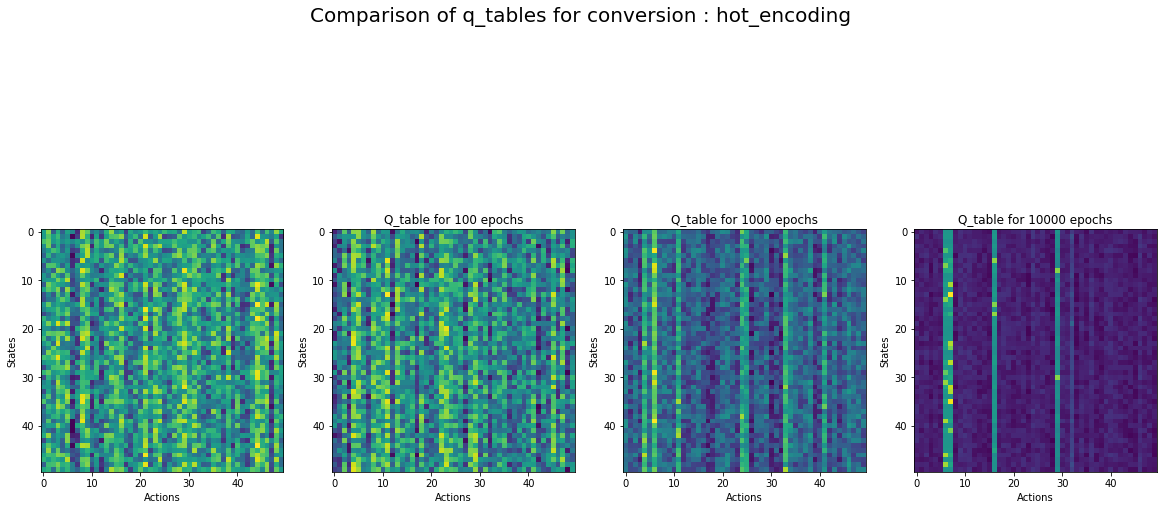

Matrix reward


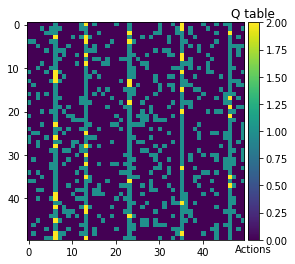

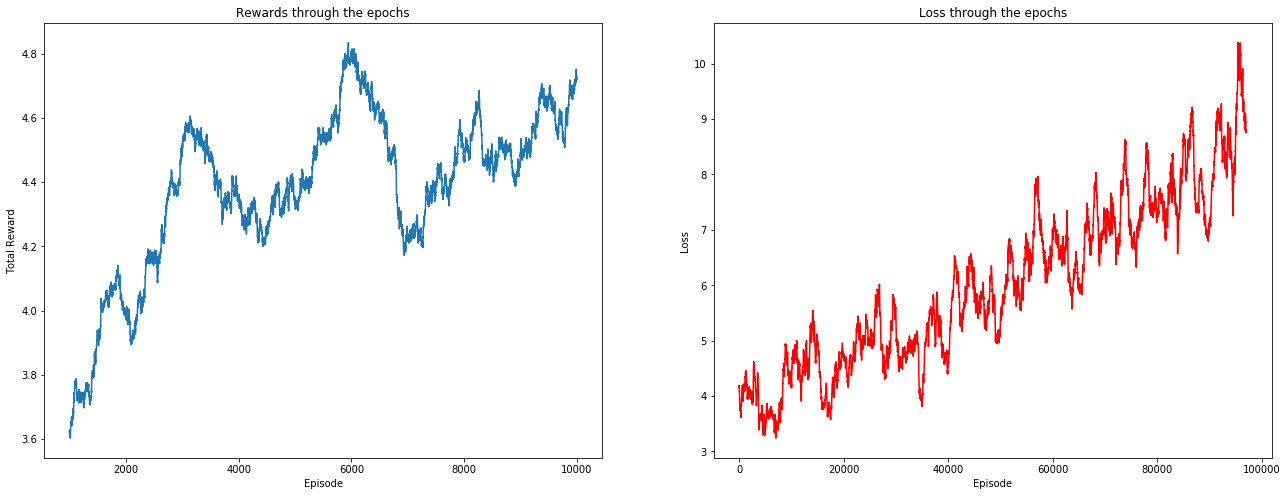

In [61]:

plot_result_deep_q([1, 100,1000 , 10000],'hot_encoding', *dict_results['hot_encoding'],\
                   param_deep_Q, rm = 1000)

## 4. U matrix



### 4.1 Full u matrix

$$ \LARGE \Phi(S_t = i ) = u_i   $$

In [ ]:
dict_results['u'] = compare_conversion('u', param_deep_Q,\
                                                  epochs = [1, 100,1000 , 10000])

Episode: 6229/10000, Reward : 0


In [ ]:

plot_result_deep_q([1, 100,1000 , 10000],'u', *dict_results['u'],\
                   param_deep_Q, rm = 1000)

### 4.2 U relevant indexes


$$ \LARGE \Phi(S_t = i ) = (\delta_{i,j})_{1 \le j \le n  } \text{ where } \delta_{i,j}
\begin{cases}
    1& \text{if } u_{i,j} \ne 0   \\
    0             & \text{otherwise}
\end{cases}  $$

In [ ]:
dict_results['u_hot'] = compare_conversion('u_hot', param_deep_Q,\
                                                  epochs = [1, 100,1000 , 10000])

In [ ]:

plot_result_deep_q([1, 100,1000 , 10000],'u_hot', *dict_results['u_hot'],\
                   param_deep_Q, rm = 1000)

## 5. Rewards


$$ \LARGE \Phi(S_t = i ) = (\delta_{i,j})_{1 \le j \le n  } \text{ where } \delta_{i,j} 
\begin{cases}
    2& \text{if j is cached and related}   \\
    1 & \text{if j is cached and not related or related and not cached} \\
    0 & \text{otherwise} 
\end{cases}  $$

In [ ]:
dict_results['rewards'] = compare_conversion('rewards', param_deep_Q,\
                                                  epochs = [1, 100,1000 , 10000])

In [ ]:

plot_result_deep_q([1, 100,1000 , 10000],'rewards', *dict_results['rewards'],\
                   param_deep_Q, rm = 1000)

# Comparison of the loss 

In [118]:
def compare_loss(all_loss, titles, rm = 100) : 
    f, axs = plt.subplots(2,3,figsize=(14,8))
    axs = axs.reshape(-1,1)
    plt.subplots_adjust(left=0.125, bottom=0, right=1.9, top=1, wspace=0.1, hspace=0.3)
    
    for i,loss in enumerate(all_loss) : 

        smoothed = running_mean(loss, rm)
        
        axs[i][0].plot(smoothed, color = 'r', label='Running mean of size : {}'.format(rm))
        axs[i][0].plot(loss, color='grey', alpha=0.3, label = 'Loss')
        axs[i][0].set_xlabel('Epochs')
        axs[i][0].set_ylabel('Loss')
        axs[i][0].set_title(titles[i])
        axs[i][0].legend()
    plt.show()
    
    
    

In [119]:
loss_to_compare = [list_agent_identity[-1].all_loss, list_agent_hot_encoding[-1].all_loss,\
                  list_agent_cached[-1].all_loss, list_agent_u[-1].all_loss,list_agent_u_hot_encoding[-1].all_loss,\
                  list_agent_rewards[-1].all_loss]
titles_to_compare = ['Identity states','One Hot encoded state','Cached states','Full U matrix states','Hot encoded U matrix states',\
                    'Reward states']

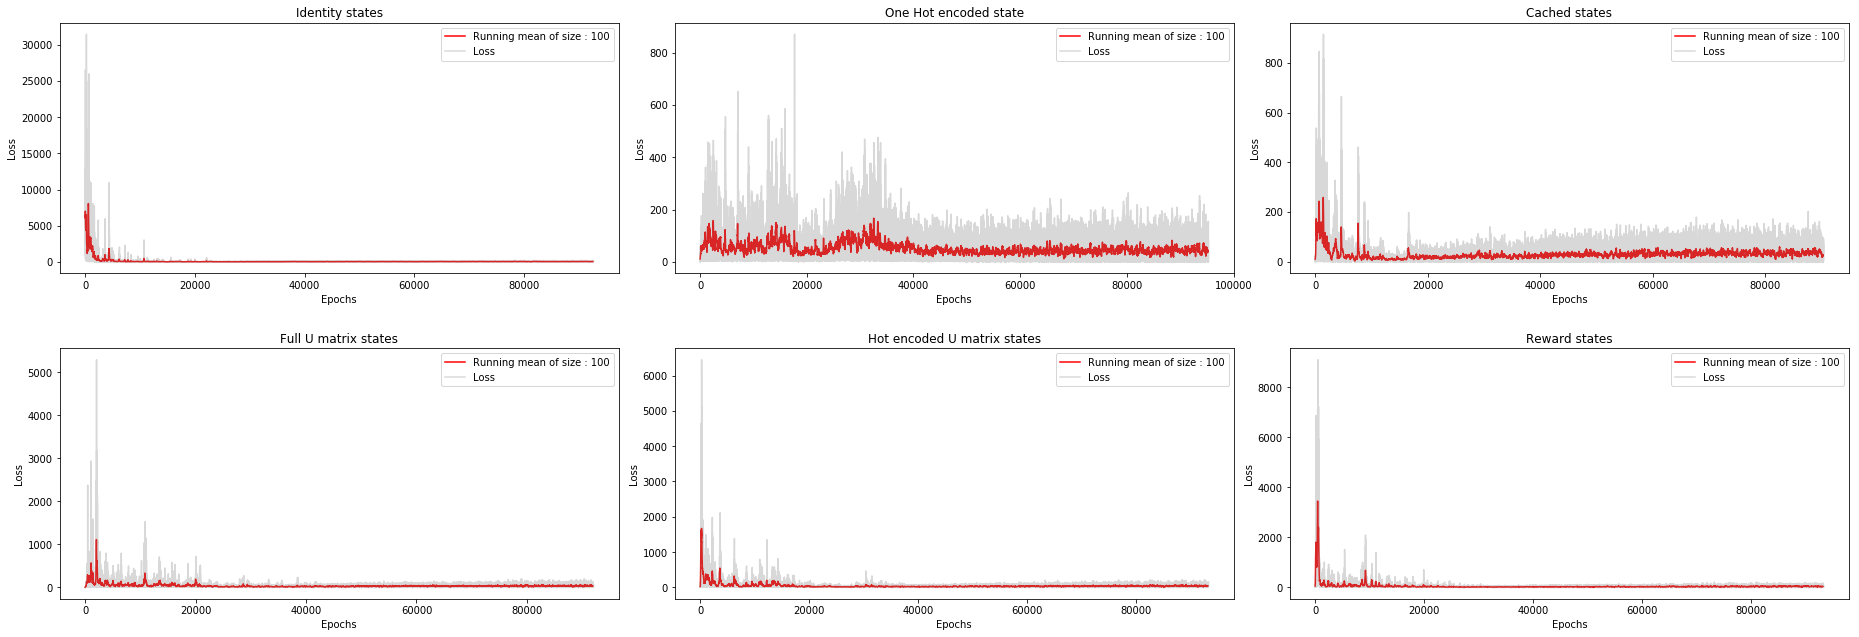

In [120]:
compare_loss(loss_to_compare,titles_to_compare)

In [ ]:
def plot_reward_loss(reward, loss, run_mean = 10) : 
    
    eps, rews = np.array(reward).T

    f, axs = plt.subplots(1,2,figsize=(22,8))

    smoothed_rews = running_mean(rews, run_mean)
    smoothed_loss = running_mean(loss, run_mean)
    
    
    axs[0].plot(eps[-len(smoothed_rews):], smoothed_rews)
    axs[0].plot(eps, rews, color='grey', alpha=0.3)
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title('Rewards through the epochs')
    
    axs[1].plot(smoothed_loss, color = 'r')
    axs[1].plot(loss, color='grey', alpha=0.3)
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Loss through the epochs')
    
    plt.show()
    

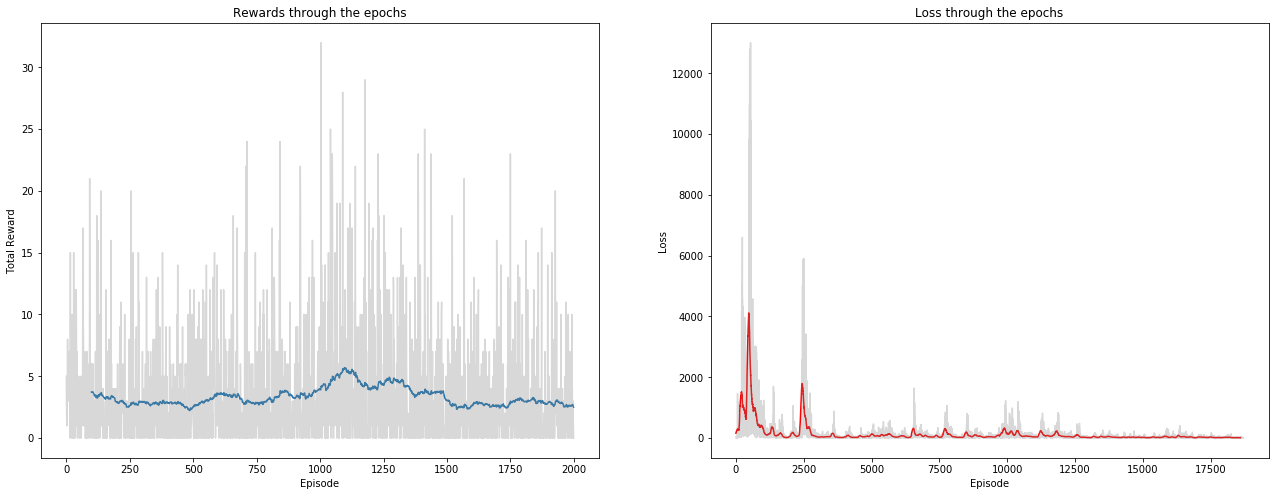

In [111]:
plot_reward_loss(reward,agent.all_loss,run_mean=100)

In [139]:
import pickle

# Saving the objects:
with open('agents.pkl', 'wb') as f: 
    pickle.dump([list_agent_identity, list_agent_hot_encoding,list_agent_cached ,list_agent_u , list_agent_u_hot_encoding,list_agent_rewards], f)

In [15]:
import pickle 
with open("agents.pkl", "rb") as f:
    [list_agent_identity, list_agent_hot_encoding,list_agent_cached ,list_agent_u , list_agent_u_hot_encoding,list_agent_rewards] = pickle.load(f)

In [141]:
def compute_rewards(param_deep_Q ,max_iter) : 
    # Return the rewards for each algorithm for max_iter epochs
    
    all_rewards = []
    all_q_tables = []
    
    for name in dict_conversion : 
         
        param_deep_Q['state_dim'] = dict_conversion[name]
        param_deep_Q['name_conversion_state'] = name
        
        param_deep_Q['max_iter'] = max_iter
        
        agent, rewards = deep_q_learning(**param_deep_Q)
    
        all_rewards.append(rewards)
        all_q_tables.append(agent.evaluate_q_values(np.arange(50)))
        
        
    return all_rewards
    
    
    

In [142]:
all_q_tables , all_rewards = compute_rewards(param_deep_Q,1000)

Episode: 335/1000, Reward : 8


KeyboardInterrupt: 

In [150]:
def compare_reward(all_reward, titles, rm = 100) : 
    f, axs = plt.subplots(2,3,figsize=(14,8))
    axs = axs.reshape(-1,1)
    plt.subplots_adjust(left=0.125, bottom=0, right=1.9, top=1, wspace=0.1, hspace=0.3)
    
    for i,reward in enumerate(all_reward) : 
        
        rew = [reward[i][1] for i in range(len(reward))]
        smoothed = running_mean(rew, rm)
        
        axs[i][0].plot(smoothed, color = 'b', label='Running mean of size : {}'.format(rm))
        axs[i][0].plot(rew, color='grey', alpha=0.3, label = 'Reward')
        axs[i][0].set_xlabel('Epochs')
        axs[i][0].set_ylabel('Loss')
        axs[i][0].set_title(titles[i])
        axs[i][0].legend()
    plt.show()
    
    
    

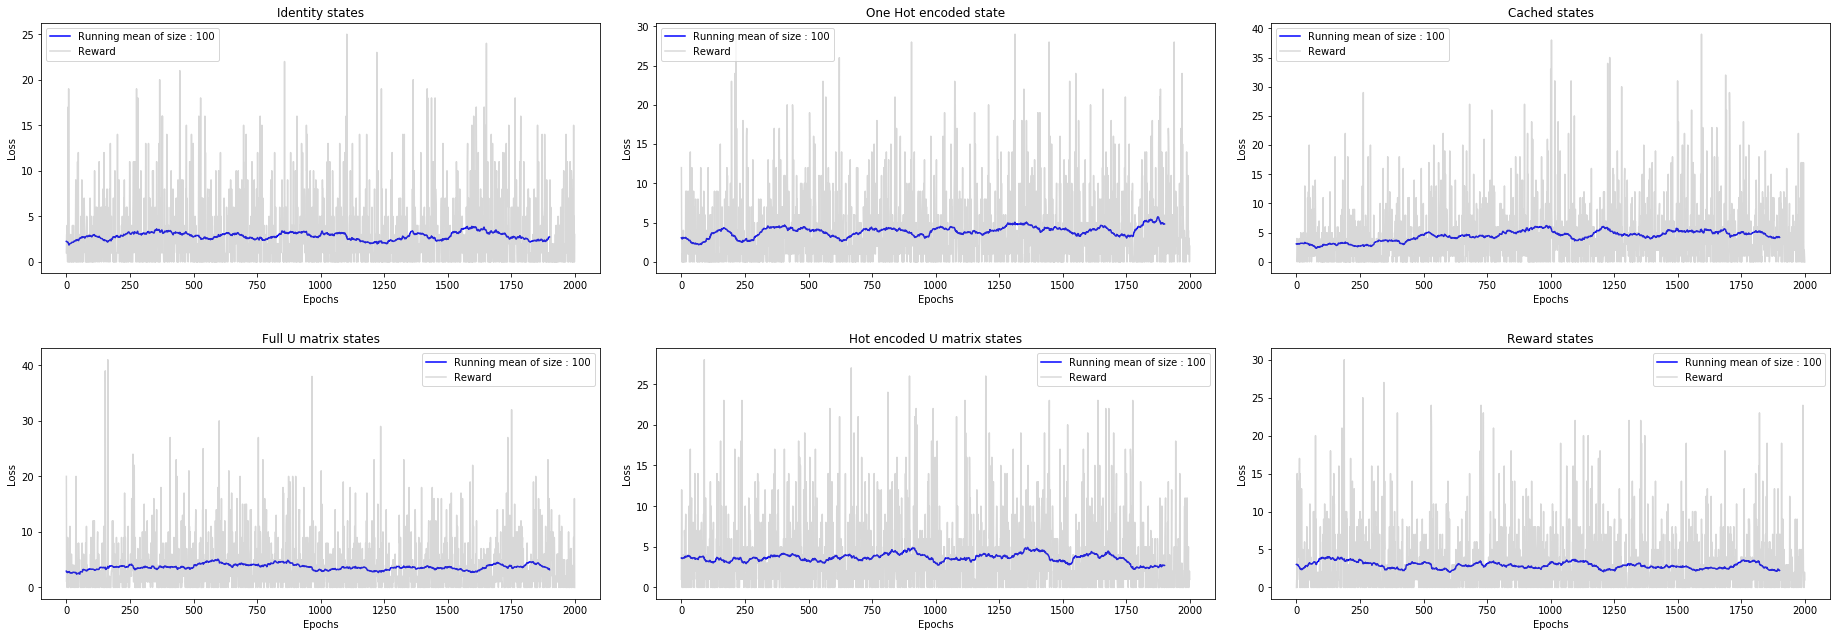

In [152]:
compare_reward(all_rewards,titles_to_compare, rm=100)